In [2]:
import keras
import tensorflow as tf
print(keras.__version__)
print(tf.__version__)

2.3.1
2.0.0


In [3]:
BATCH_SIZE = 48
EDGE_CROP = 16
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = (1, 1)
# downsampling in preprocessing
IMG_SCALING = (3, 3)
# number of validation images to use
VALID_IMG_COUNT = 900
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 9
MAX_TRAIN_EPOCHS = 99
AUGMENT_BRIGHTNESS = False

In [4]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
#from skimage.util.montage import montage2d as montage
path = "/mnt/3CE35B99003D727B/input/kaggle/Airbus Ship Detection Challenge/"
from keras import models, layers

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


masks = pd.read_csv(os.path.join(path + 'train_ship_segmentations_v2.csv'))

print(masks.shape[0],'masks found')

masks.head()

231723 masks found


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [5]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries
from skimage.util import montage2d as montage
from skimage.morphology import binary_opening, disk, label
import gc; gc.enable() # memory is tight

montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = path
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')

def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4
0 error


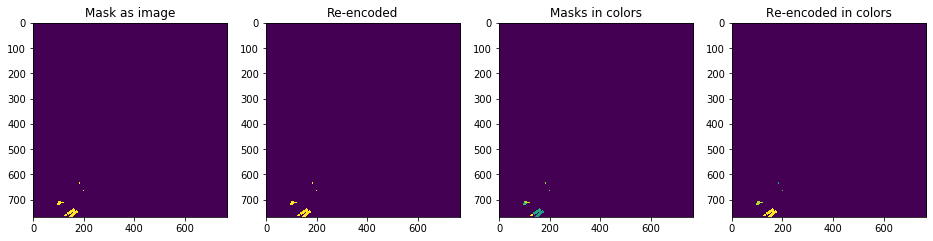

In [5]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (16, 5))
rle_0 = masks.query('ImageId=="00021ddc3.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0)
ax1.set_title('Mask as image')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1)
ax2.set_title('Re-encoded')
img_c = masks_as_color(rle_0)
ax3.imshow(img_c)
ax3.set_title('Masks in colors')
img_c = masks_as_color(rle_1)
ax4.imshow(img_c)
ax4.set_title('Re-encoded in colors')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))
print(np.sum(img_0 - img_1), 'error')

,ImageId,ships,has_ship,has_ship_vec,file_size_kb
89370,76a5db9f9.jpg,0,0.0,[0.0],99.680664
125155,a6773165f.jpg,0,0.0,[0.0],138.860352
30001,27d083e59.jpg,0,0.0,[0.0],106.958008
152787,cb3a0fbed.jpg,0,0.0,[0.0],174.122070
134691,b31264e7d.jpg,0,0.0,[0.0],111.801758
151076,c8e53d672.jpg,0,0.0,[0.0],115.170898
85405,7179e12e2.jpg,0,0.0,[0.0],198.655273


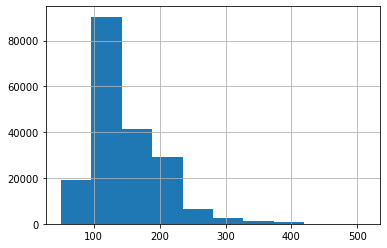

In [6]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join(train_image_dir, 
                                                                                    c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] > 50] # keep only +50kb files
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(7)

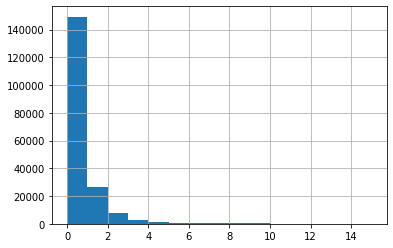

In [7]:
unique_img_ids['ships'].hist(bins=unique_img_ids['ships'].max())

12788 masks


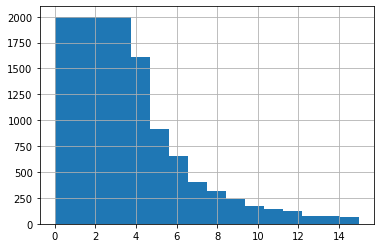

In [8]:
SAMPLES_PER_GROUP = 2000
balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)
print(balanced_train_df.shape[0], 'masks')

In [9]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(balanced_train_df, 
                 test_size = 0.2, 
                 stratify = balanced_train_df['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

35364 training masks
8838 validation masks


In [10]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = imread(rgb_path)
            c_mask = np.expand_dims(masks_as_image(c_masks['EncodedPixels'].values), -1)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

In [11]:
train_gen = make_image_gen(train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (48, 256, 256, 3) 0.0 1.0
y (48, 256, 256, 1) 0 1


/home/jake/venv/lib/python3.7/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/home/jake/venv/lib/python3.7/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/home/jake/venv/lib/python3.7/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/home/jake/venv/lib/python3.7/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montag

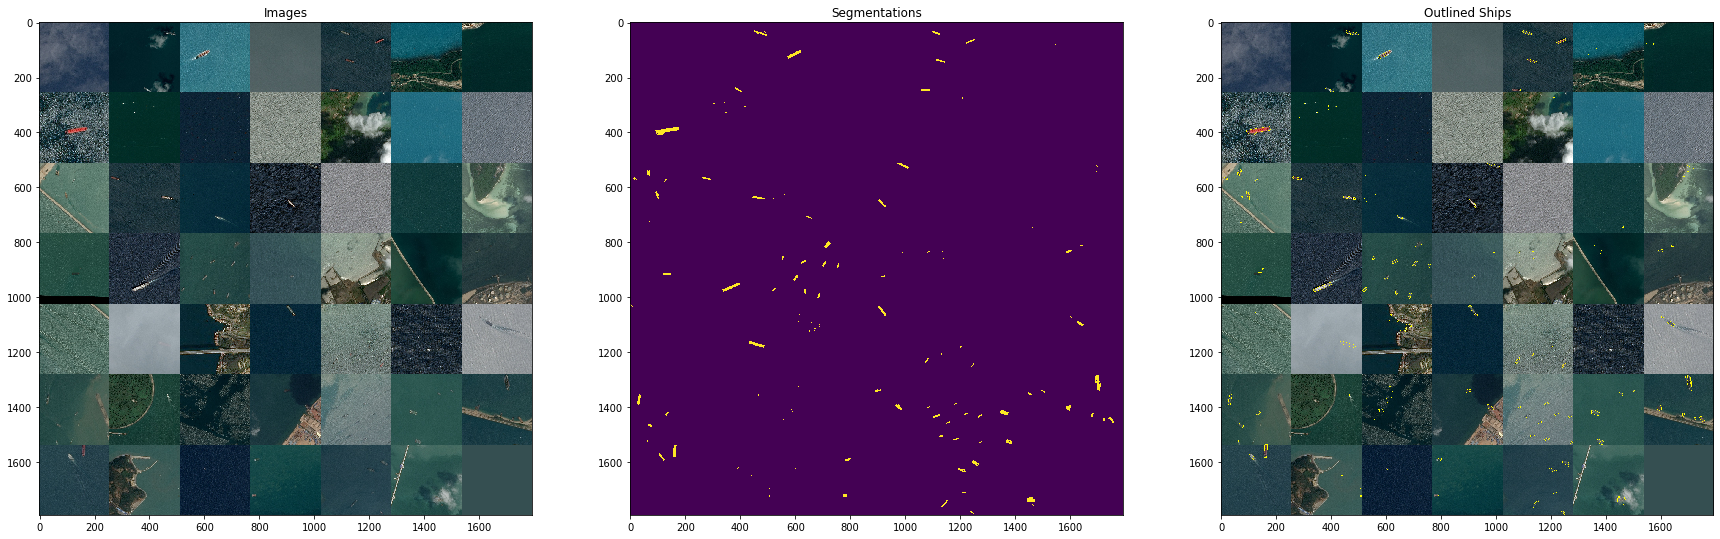

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, 
                           batch_seg.astype(int)))
ax3.set_title('Outlined Ships')
fig.savefig('overview.png')

In [13]:
%%time
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

(900, 256, 256, 3) (900, 256, 256, 1)
CPU times: user 11.4 s, sys: 2.1 s, total: 13.5 s
Wall time: 20.6 s


In [14]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect')
# brightness can be problematic since it seems to change the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

x (48, 256, 256, 3) float32 0.0 1.0
y (48, 256, 256, 1) float32 0.0 1.0


/home/jake/venv/lib/python3.7/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/home/jake/venv/lib/python3.7/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/home/jake/venv/lib/python3.7/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/home/jake/venv/lib/python3.7/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montag

Text(0.5, 1.0, 'ships')

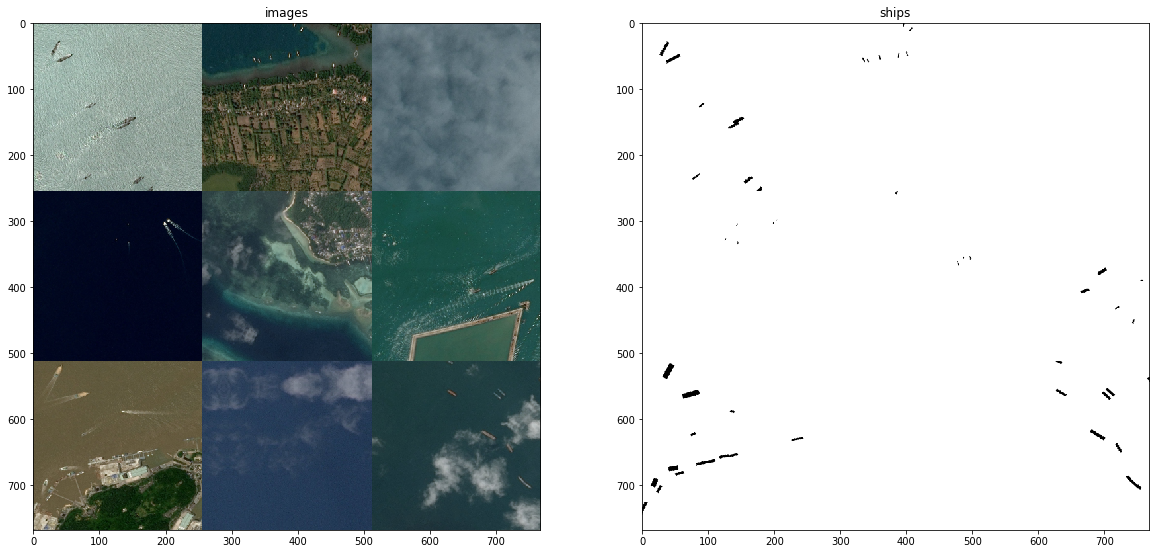

In [15]:
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('images')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')
ax2.set_title('ships')

In [16]:
gc.collect()

27

# Build model

In [2]:
from keras_unet.models import vanilla_unet

Using TensorFlow backend.


In [ ]:
model = vanilla_unet(input_shape=(256, 256, 3))